In [3]:
# Assistants 
""" WRA -- Web research assistant -- Can repeatedly research the web given a query """
""" ERA -- ERP assistant - familiar with internal APIs to pull (and post) data """ 
""" LIA -- Linkedin assistant - generates content to post - input: tone, keywords, company specific details """
""" PCA -- Python coding assistant - Can code in python - especially useful for mathematical operations which LLMs can be bad at """ 
""" PRA -- Product assistant - has knowledge of internal product datasheets and catalogue """

# Employees
""" Marketing engineer -- WRA + LIA + PRA (+ ERA) """ 
""" Sales engineer     -- WRA + ERA + PRA         """ 
""" Data Analyst       -- ERA + PCA               """ 


' Data Analyst       -- ERA + PCA               '

In [125]:
from typing import Annotated, List
from langchain_openai import ChatOpenAI
from langchain.callbacks.tracers.langchain import wait_for_all_tracers
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

In [126]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages

def make_supervisor_node(llm: BaseChatModel, members: list[str], custom_system_prompt: str | None = None) -> str:
    options = ["FINISH"] + members
    default_system_prompt = (
        " You are a supervisor tasked with managing a conversation between the"
        " following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. If the worker responds with partial information," 
        " consider calling another worker to get all the information you need. When you are done, or don't have any worker who could help,"
        " respond with FINISH."
        " Whenever you use the Linkedin post assistant, you should provide it all the information so that it does not hallucinate"
    )
    
    system_prompt = custom_system_prompt if custom_system_prompt is not None else default_system_prompt

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""
        next: Literal[*options]

    def supervisor_node(state: MessagesState) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto)

    return supervisor_node

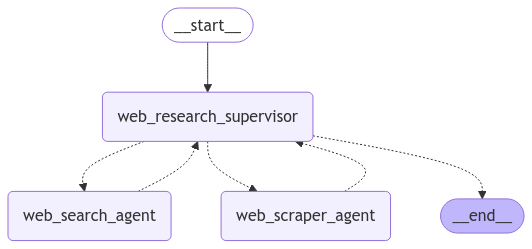

In [129]:
""" Web research assistant -- Can repeatedly research the web given a query """

from langchain_core.messages import HumanMessage , SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from langchain_community.chat_models import ChatPerplexity

llm = ChatOpenAI(model="gpt-4o-mini")


""" Web query search agent """ 
tavily_tool = TavilySearchResults(max_results=5)
@tool
def perplexity_search(query: str) -> str:
    """Search the web using Perplexity AI."""
    chat = ChatPerplexity(temperature=0.7, model="llama-3.1-sonar-small-128k-online")
    response = chat.invoke(query)
    return response.content

web_prompt =""" 
Your only task is to return the data that you get using tools , Dont do any other tasks like writing linkedin posts etc
when something varies on several factors, try to give a genral idea in ranges.
"""
search_agent = create_react_agent(llm, tools=[perplexity_search],state_modifier=SystemMessage(content=web_prompt))

def search_node(state: MessagesState) -> Command[Literal["web_research_supervisor"]]:
    
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_search_agent")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="web_research_supervisor",
    )


""" Extract webpage agent """ 
@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )
scrap_prompt= """Your only task is to scrape webpages . 
You have to find the answer in given webpages .Dont do anything else like writing linkedin posts etc. 
"""
web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages],state_modifier=SystemMessage(content=scrap_prompt))
def web_scraper_node(state: MessagesState) -> Command[Literal["web_research_supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper_agent")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="web_research_supervisor",
    )

""" Web research supervisor """ 
custom_prompt = """
You are a supervisor tasked with managing a conversation between web_search_agent, web_scrapper_agent and FINISH . Given a user request
respond with the worker to act next. web_search_agent is responsible for searching the internet and returning the related information .
web_scraper_agent can return the data contained in given url .It cant do any other task
When you have the exact answer, or don't have any worker who could help respond with FINISH.

"""
web_research_supervisor_node = make_supervisor_node(llm, ["web_search_agent", "web_scraper_agent"],custom_prompt)

web_research_builder = StateGraph(MessagesState)
web_research_builder.add_node("web_research_supervisor", web_research_supervisor_node)
web_research_builder.add_node("web_search_agent", search_node)
web_research_builder.add_node("web_scraper_agent", web_scraper_node)

web_research_builder.add_edge(START, "web_research_supervisor")
web_research_graph = web_research_builder.compile()

display(Image(web_research_graph.get_graph().draw_mermaid_png()))

In [131]:
initial_state = {
    "messages": [
        HumanMessage(content="number of vehicles exported by toyota in october 2024 in india")
    ]
}
result = web_research_graph.invoke(initial_state)
print("Result from the web research agent:")
for message in result["messages"]:
    print(f"{message.name}: {message.content}")

Result from the web research agent:
None: number of vehicles exported by toyota in october 2024 in india
web_search_agent: In October 2024, Toyota exported a total of 2,707 units of passenger vehicles from India.


In [17]:
""" ERP assistant - familiar with internal APIs to pull and post data """ 

"""
--- Tables --- 
Customer Phone | Customer Area | Customer Name | Sales Engineer 
Inquiry ID | Customer phone | Payment | History <previous inquiry IDs from same customer> | Last update date 
Inquiry ID | Order ID | Order type | Quoted Price | Cost | Order Status | Discount 
"""

""" 
--- Fields --- 
Customer Area  - RAK, FJ, SHJ, DXB, AJM, UQ, AD
Sales Engineer - Balaji, Shweta, Joseph, Rinshad, Saurabh, Prashant, Ashwin
Order Type     - Festo Parts, Service, Compressors, Piping, Machine
Order Status   - Call Inquiry, Sales inquiry, Ready to Quote, Quotation made, Order requested, Order Processed
"""

""" 
--- Types of Queries ---
1. Daily top N summary
2. How many customers are in call inquiry phase ? 
3. What is the max discount to apply to a specific inquiry ?  
""" 

' ERP assistant - familiar with internal APIs to pull and post data. If data is pulled - it must bbe returned in a tabular format '

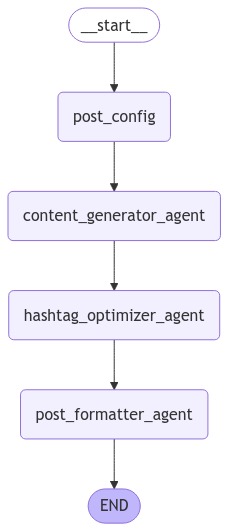

In [90]:
from typing import List, Dict, Literal, Optional
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, MessagesState
from dataclasses import dataclass
from IPython.display import Image, display

llm = ChatOpenAI(model="gpt-4o-mini")

@dataclass
class PostConfig:
    """Configuration for LinkedIn post generation"""
    tone: str
    keywords: List[str]
    company_details: Dict[str, str]
    target_audience: str
    post_length: str
    industry: str
    call_to_action: Optional[str] = None

def extract_config_from_query(query: str) -> PostConfig:
    """Extract post configuration from user query"""
    system_prompt = """You are a post configuration expert. Analyze the user's query and extract:
    1. Tone of the post
    2. Target audience
    3. Company name and details
    4. Industry (if mentioned)
    5. Keywords (extract from context)
    6. Post length (if specified)
    7. Call to action (if specified)
    
    For unspecified parameters, use these defaults:
    - tone: professional and engaging (if not specified)
    - keywords: [innovation, technology, growth]
    - industry: Technology
    - post_length: medium
    - call_to_action: Learn more on our website
    
    Return ONLY a Python dictionary format like this:
    {
        "tone": "extracted_tone",
        "keywords": ["keyword1", "keyword2"],
        "company_details": {"name": "company_name", "industry": "industry", "value_proposition": "value_prop"},
        "target_audience": "extracted_audience",
        "post_length": "medium",
        "industry": "extracted_industry",
        "call_to_action": "extracted_cta"
    }"""
    
    config_agent = create_react_agent(
        llm,
        tools=[],
        state_modifier=SystemMessage(content=system_prompt)
    )
    
    result = config_agent.invoke({
        "messages": [HumanMessage(content=f"Extract configuration from: {query}")]
    })
    
    # Safely evaluate the Python dictionary from the response
    config_dict = eval(result["messages"][-1].content)
    return PostConfig(**config_dict)

# Post Configuration Node
def post_config_node(state: MessagesState):
    # Get the user query from the initial message
    user_query = state["messages"][0].content
    
    # Extract configuration
    config = extract_config_from_query(user_query)
    
    # Create the content generator agent with the extracted config
    global content_generator_agent
    content_generator_agent = create_content_generator_agent(llm, config)
    
    # Return next node to visit
    return {"goto": "content_generator_agent"}

# Content Generator Agent
def create_content_generator_agent(llm, config: PostConfig):
    system_prompt = f"""You are a professional LinkedIn content creator. Generate posts with the following specifications:
    - Tone: {config.tone}
    - Target Audience: {config.target_audience}
    - Industry: {config.industry}
    - Post Length: {config.post_length}
    - Keywords to include: {', '.join(config.keywords)}
    - Company Details: {config.company_details}
    
    Guidelines:
    1. Maintain consistent brand voice
    2. Include relevant hashtags
    3. Optimize for engagement
    4. Include a clear call-to-action: {config.call_to_action if config.call_to_action else 'Based on post context'}
    """
    
    return create_react_agent(
        llm,
        tools=[],
        state_modifier=SystemMessage(content=system_prompt)
    )

def content_generator_node(state: MessagesState):
    result = content_generator_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(
                content=result["messages"][-1].content,
                name="content_generator_agent"
            )
        ]
    }

# Hashtag Optimizer Agent
hashtag_system_prompt = """You are a LinkedIn hashtag optimization specialist.
Your role is to analyze the post content and add relevant, trending hashtags that will maximize visibility.
Ensure hashtags are naturally integrated and don't overwhelm the post."""

hashtag_optimizer_agent = create_react_agent(
    llm,
    tools=[],
    state_modifier=SystemMessage(content=hashtag_system_prompt)
)

def hashtag_optimizer_node(state: MessagesState):
    result = hashtag_optimizer_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(
                content=result["messages"][-1].content,
                name="hashtag_optimizer_agent"
            )
        ]
    }

# Post Formatter Agent
formatter_system_prompt = """You are a LinkedIn post formatting specialist.
Your role is to ensure the post follows LinkedIn best practices for formatting:
1. Use appropriate line breaks for readability
2. Ensure proper emoji placement
3. Format lists and bullet points effectively
4. Position hashtags optimally
5. Highlight key points using appropriate formatting techniques"""

post_formatter_agent = create_react_agent(
    llm,
    tools=[],
    state_modifier=SystemMessage(content=formatter_system_prompt)
)

def post_formatter_node(state: MessagesState):
    result = post_formatter_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(
                content=result["messages"][-1].content,
                name="post_formatter_agent"
            )
        ]
    }

# Build the graph
linkedin_post_builder = StateGraph(MessagesState)

# Add nodes
linkedin_post_builder.add_node("post_config", post_config_node)
linkedin_post_builder.add_node("content_generator_agent", content_generator_node)
linkedin_post_builder.add_node("hashtag_optimizer_agent", hashtag_optimizer_node)
linkedin_post_builder.add_node("post_formatter_agent", post_formatter_node)
linkedin_post_builder.add_node("END", lambda state: state)

# Add edges
linkedin_post_builder.add_edge("post_config", "content_generator_agent")
linkedin_post_builder.add_edge("content_generator_agent", "hashtag_optimizer_agent")
linkedin_post_builder.add_edge("hashtag_optimizer_agent", "post_formatter_agent")
linkedin_post_builder.add_edge("post_formatter_agent", "END")

# Set the entry point
linkedin_post_builder.set_entry_point("post_config")

# Compile the graph
linkedin_post_graph = linkedin_post_builder.compile()
display(Image(linkedin_post_graph.get_graph().draw_mermaid_png()))


In [ ]:
"""POST CONFIG  -> EXTRACTS TONE , TARGET AUDIENCE etc etc from the messgae"""
"""CONTENT GENERATOR -> GENERATES MESSAGE """
"""HASHTAG OPTIMIZER -> FINDS TOO MANY HASHTAGS """
"""POST FORMATTER -> PLACES EMOJIS """

In [ ]:
# Example usage
initial_state = {
    "messages": [
        {
            "role": "user",
            "content": "make an exciting post targeted to students about Xyro"
        }
    ]
}

final_state = linkedin_post_graph.invoke(initial_state)
result = final_state["messages"][-1].content
print("Final Result:", result)

<>:17: SyntaxWarning: invalid escape sequence '\`'
<>:17: SyntaxWarning: invalid escape sequence '\`'
<>:17: SyntaxWarning: invalid escape sequence '\`'
<>:17: SyntaxWarning: invalid escape sequence '\`'
C:\Users\mehta\AppData\Local\Temp\ipykernel_29048\1544512436.py:17: SyntaxWarning: invalid escape sequence '\`'
  return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\mehta\AppData\Local\Temp\ipykernel_29048\1544512436.py:17: SyntaxWarning: invalid escape sequence '\`'
  return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


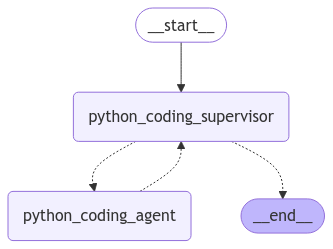

In [73]:
""" Python coding assistant """ 
""" Can code in python - especially useful for mathematical operations which LLMs can be bad at """ 

# Warning: This executes code locally, which can be unsafe when not sandboxed
""" Python execution tool """ 
repl = PythonREPL()
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


"""Python coding agent """ 
python_coding_agent = create_react_agent(llm, tools=[python_repl_tool],)
def python_coding_node(state: MessagesState) -> Command[Literal["python_coding_supervisor"]]:
    result = python_coding_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="python_coding_agent")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="python_coding_supervisor",
    )

""" Python coding supervisor """ 
python_coding_supervisor_node = make_supervisor_node(llm, ["python_coding_agent"])

python_coding_builder = StateGraph(MessagesState)
python_coding_builder.add_node("python_coding_supervisor", python_coding_supervisor_node)
python_coding_builder.add_node("python_coding_agent", python_coding_node)
python_coding_builder.add_edge(START, "python_coding_supervisor")
python_coding_graph = python_coding_builder.compile()

display(Image(python_coding_graph.get_graph().draw_mermaid_png()))

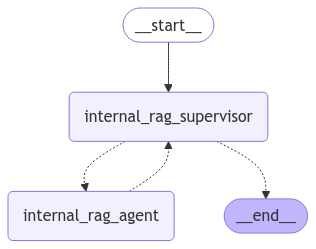

In [133]:
""" Interlal RAG assistant """ 
""" Can query internal documentation for information about products """ 
import json
import numpy as np 
import sys
from pinecone import Pinecone
from pinecone_plugins.assistant.models.chat import Message
pc = Pinecone(api_key="pcsk_6bAB1m_GbZ1hAsB5wah4Sted9k6GSrmwtxJgzfCt5QmkYembV13PguS7KPob59o4RKjUvx")

""" interal RAG tool """ 

@tool
def internal_rag_tool(
    query: Annotated[str, "The query on internal product information that will be answered by this chat assistant."],
) -> str:
    """ Use this for internal product information retrieval. The call is to a RAG service setup with pinecone """
    try:
        # assistant = pc.assistant.create_assistant(
        #     assistant_name="example-assistant-3", 
        #     instructions="Use American English for spelling and grammar.", 
        #     timeout=30 
        # )
        # response = assistant.upload_file(
        #     file_path="prd.pdf",
        #     timeout=None
        # )
        assistant = pc.assistant.Assistant(assistant_name="example-assistant-3")
        msg = Message(role="user", content=query)
        resp = assistant.chat(messages=[msg])
        return resp
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"


""" Internal RAG agent """ 
system_prompt="""
       You have only one task that you should retrieve whatever information related to the query is in internal documents.
       Just return the information you have and dont do any other tasks like writing Linkedin Posts etc
"""
internal_rag_agent = create_react_agent(llm, tools=[internal_rag_tool],state_modifier=SystemMessage(content=system_prompt))
def internal_rag_node(state: MessagesState) -> Command[Literal["internal_rag_supervisor"]]:
    result = internal_rag_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="internal_rag_agent")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="internal_rag_supervisor",
    )

""" Internal RAG supervisor """ 
rag_supervisor_prompt = """ 
You are a supervisor tasked with choosing between internal_rag_agent and FINISH. Given a user request
respond with the worker to act next. Given a user query you should ask the internal_rag_agent to 
When you have the exact answer, or don't have any worker who could help respond with FINISH.

"""
internal_rag_supervisor_node = make_supervisor_node(llm, ["internal_rag_agent"],)

internal_rag_builder = StateGraph(MessagesState)

internal_rag_builder.add_node("internal_rag_supervisor", internal_rag_supervisor_node)
internal_rag_builder.add_node("internal_rag_agent", internal_rag_node)
internal_rag_builder.add_edge(START, "internal_rag_supervisor")
internal_rag_graph = internal_rag_builder.compile()

display(Image(internal_rag_graph.get_graph().draw_mermaid_png()))


In [206]:
initial_state = {
    "messages": [
        {
            "role": "user", 
            "content": "What is Xyro's aim?"  
        }
    ]
}

final_state = internal_rag_graph.invoke(initial_state)
result = final_state["messages"][-1].content
print("Final Result:", result)

Final Result: XyRo aims to revolutionize sales processes by deploying AI-powered assistants tailored to specific tasks. The initial Proof of Concept (POC) will demonstrate the capabilities of two digital employees: a Data Analyst and a Marketing Engineer. Although a Sales Engineer digital employee is not included in the initial POC, its role is outlined for potential future development. Each digital employee will integrate with relevant assistants to streamline operations, improve efficiency, and provide actionable insights.


In [134]:
""" Create a node for web research assistant """ 
def web_research_assistant(state: MessagesState) -> Command[Literal["xyro_employee_base"]]:
    result = web_research_graph.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_research_assistant")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="xyro_employee_base",
    )

""" Create a node for coding assistant """ 
def python_coding_assistant(state: MessagesState) -> Command[Literal["xyro_employee_base"]]:
    result = python_coding_graph.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="python_coding_assistant")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="xyro_employee_base",
    )


""" Create a node for RAG assistant """ 
def internal_rag_assistant(state: MessagesState) -> Command[Literal["xyro_employee_base"]]:
    result = internal_rag_graph.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="internal_rag_assistant")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="xyro_employee_base",
    )

""" TODO: Create a node for Linkedin assistant """ 

def linkedin_post_assistant(state: MessagesState) -> Command[Literal["xyro_employee_base"]]:
    result = linkedin_post_graph.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="linkedin_post_assistant")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="xyro_employee_base",
    )

""" TODO: Create a node for ERP assistant """ 

""" TODO: Create a node for Tabular assistant """ 


' TODO: Create a node for Tabular assistant '

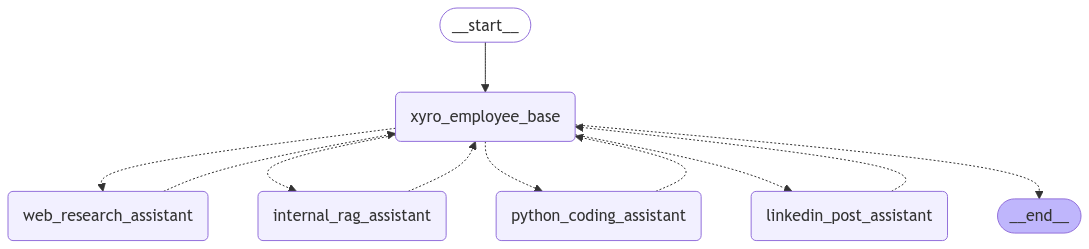

In [135]:
""" XyRo Employee base 1"""
xyro_employee_base_node = make_supervisor_node(llm, ["web_research_assistant", "internal_rag_assistant", "python_coding_assistant", "linkedin_post_assistant"])

xyro_employee_base_node_builder = StateGraph(MessagesState)
xyro_employee_base_node_builder.add_node("xyro_employee_base", xyro_employee_base_node)
xyro_employee_base_node_builder.add_node("web_research_assistant", web_research_assistant)
xyro_employee_base_node_builder.add_node("internal_rag_assistant", internal_rag_assistant)
xyro_employee_base_node_builder.add_node("python_coding_assistant", python_coding_assistant)
xyro_employee_base_node_builder.add_node("linkedin_post_assistant", linkedin_post_assistant)
xyro_employee_base_node_builder.add_edge(START, "xyro_employee_base")
xyro_employee_base_graph = xyro_employee_base_node_builder.compile()

display(Image(xyro_employee_base_graph.get_graph().draw_mermaid_png()))

In [136]:
# Search the web if there are other companies with similar executive summary. Then write python code to compute the square of the number of companies
#make an exciting linkedin post about xyro using our internal documents
#make an exciting linkedin post about xyro using our internal documents and its cometitor
for s in xyro_employee_base_graph.stream(
    {
        "messages": [
            ("user", "make an exciting linkedin post about xyro using our internal documents and its cometitor")
        ],
    },
    {"subgraphs":True,
    "recursion_limit": 25},
):
    print(s)
    print("---")

{'xyro_employee_base': None}
---
{'internal_rag_assistant': {'messages': [HumanMessage(content="I was unable to find specific information about XyRo's competitors in the internal documents. However, I do have details regarding XyRo's Proof of Concept (POC) for AI-powered assistants, focusing on roles such as Data Analyst, Marketing Engineer, and the future Sales Engineer, alongside their technical implementation and development plans.\n\nIf you would like to know more about XyRo or need information from another source, please let me know!", additional_kwargs={}, response_metadata={}, name='internal_rag_assistant', id='6f2c593f-5a25-4987-8026-a0a6b0223421')]}}
---
{'xyro_employee_base': None}
---
{'web_research_assistant': {'messages': [HumanMessage(content='XyRo is making waves in the AI-powered assistant space, particularly with its innovative Proof of Concept (POC) tailored for roles such as Data Analyst, Marketing Engineer, and the future Sales Engineer. With a strong technical impl

In [ ]:
""" Marketing employee """

In [ ]:
""" Data Analyst employee """

In [ ]:
""" Sales employee """